In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, rosen, rosen_der
import time
from tqdm import tqdm

In [4]:
def np_belongs(x, L):
    for i in range(len(L)):
        if np.array_equal(x, L[i]):
            return True
    return False

def cost_path(path):
    # sum of the distances between consecutive points
    cost = 0
    for i in range(len(path)-1):
        cost += np.linalg.norm(path[i] - path[i+1])
    return cost

def grid_to_real_coordinates(x, N, L):
    # convert coordinates from 0 to N-1 to coordinates from -L to L
    return 2 * L * x / (N - 1) - L

def grid_to_real_length(c, N, L):
    # convert length from 0 to N-1 to length from -L to L
    return 2 * L * c / (N - 1)

def rectangle_points(obstacle):
    # returns the list of points of the square obstacle
    # obstacle is (x1, y1, c1, c2) where (x1, y1) is the lower left corner of the square and c1 is the side length and c2 is the length of the other side
    obstacle_points = []
    for i in range(obstacle[2]):
        for j in range(obstacle[3]):
            obstacle_points.append((obstacle[0] + i, obstacle[1] + j))
    return obstacle_points

def obstacles_list_to_points(obstacle_list):
    # from list of obstacles, returns the list of points of the obstacles
    obstacle_list_points = []
    for obstacle in obstacle_list:
        obstacle_list_points += rectangle_points(obstacle)
    return obstacle_list_points

def belongs_to_rectangle(obstacle, point):
    # obstacle is (x1, y1, c1, c2) where (x1, y1) is the lower left corner of the square and c1 is the side length and c2 is the length of the other side
    # point is (x, y)
    # returns True if point is in the square
    # returns False otherwise
    if obstacle[0] <= point[0] and point[0] < obstacle[0] + obstacle[2] and obstacle[1] <= point[1] and point[1] < obstacle[1] + obstacle[3]:
        return True
    return False

def segment_intersects_segment(point_1, point_2, point_3, point_4):
    # Returns True if the segment [point_1, point_2] intersects the segment [point_3, point_4]
    # Returns False otherwise
    denominator = (point_4[1] - point_3[1]) * (point_2[0] - point_1[0]) - (point_4[0] - point_3[0]) * (point_2[1] - point_1[1])
    if denominator == 0:
        return False
    ua = ((point_4[0] - point_3[0]) * (point_1[1] - point_3[1]) - (point_4[1] - point_3[1]) * (point_1[0] - point_3[0])) / denominator
    ub = ((point_2[0] - point_1[0]) * (point_1[1] - point_3[1]) - (point_2[1] - point_1[1]) * (point_1[0] - point_3[0])) / denominator
    if 0 <= ua <= 1 and 0 <= ub <= 1:
        return True
    return False


def segment_intersects_square(point_1, point_2, rectangle):
    # Returns True if the segment [point_1, point_2] intersects the square
    # Returns False otherwise
    # square is a list of 4 points
    # square[0] is the lower left corner
    # square[1] is the lower right corner
    # square[2] is the upper right corner
    # square[3] is the upper left corner
    # square[0] = square[4]
    for i in range(4):
        if segment_intersects_segment(point_1, point_2, rectangle[i], rectangle[i+1]):
            return True
    return False

def compute_camera_visible_points(cam, obstacles_list, N):
    # returns a list of points visible from the camera when obstacles are squares
    visible_points = []
    # for each point in the grid
    for i in range(N):
        for j in range(N):
            point = np.array([i, j])
            # if the point is in the camera scope where the camera is defined by (pos, theta, angle)
            if (i != cam[0][0] or j != cam[0][1]) and np.dot((np.array([i, j]) - cam[0])/np.linalg.norm(np.array([i, j]) - cam[0]), np.array([np.cos(cam[1]), np.sin(cam[1])])) > np.cos(cam[2]/2):
                # check if the point is visible from the camera
                visible = True
                for obstacle in obstacles_list:
                    # obstacle is (x1, y1, c1, c2) where (x1, y1) is the lower left corner of the square and c1 is the side length and c2 is the length of the other side
                    rectangle = np.array([[obstacle[0], obstacle[1]], [obstacle[0] + obstacle[2] - 1, obstacle[1]], [obstacle[0] + obstacle[2] - 1, obstacle[1] + obstacle[3] - 1], [obstacle[0], obstacle[1] + obstacle[3] - 1], [obstacle[0], obstacle[1]]])
                    if segment_intersects_square(cam[0], point, rectangle):
                        visible = False
                        break
                if visible:
                    visible_points.append(point)
    # add a square of size N//5 around the camera
    # cam_size = N//5 + 1
    # for i in range(cam_size):
    #     for j in range(cam_size):
    #         # if well in the grid
    #         if cam[0][0] - cam_size//2 + i >= 0 and cam[0][0] - cam_size//2 + i < N and cam[0][1] - cam_size//2 + j >= 0 and cam[0][1] - cam_size//2 + j < N and not np_belongs(np.array([cam[0][0] - cam_size//2 + i, cam[0][1] - cam_size//2 + j]), visible_points):
    #             visible_points.append(np.array([cam[0][0] - cam_size//2 + i, cam[0][1] - cam_size//2 + j]))
    return visible_points


# NF(x) is the set of segments [xj, xk] where [xj, xk] is in AF, and there exists x' on [xj, xk] such that x' is at distance at most nfconstant from x
def compute_NF(x, AF):
    nfconstant = 1.5
    NF = []
    for i in range(len(AF)):
        # calculate the distance between x and the segment AF[i]
        # if the distance is smaller than nfconstant, add AF[i] to NF
        if np.linalg.norm(x - AF[i][0]) <= nfconstant or np.linalg.norm(x - AF[i][1]) <= nfconstant:
            # if both points are different and different from x
            if not np.array_equal(AF[i][0], AF[i][1]) and not np.array_equal(AF[i][0], x) and not np.array_equal(AF[i][1], x):
                # print(AF[i].shape)
                NF.append(AF[i])
    return NF

def exists_considered(M):
    N = M.shape[0]
    for i in range(N):
        for j in range(N):
            if M[i, j] == 1:
                return True, np.array([i,j])
    return False, 0

def compute_AcceptedFront(M, o):
    N = M.shape[0]
    AcceptedFront = []
    # fill AcceptedFront
    for i in range(N):
        for j in range(N):
            # [i, j] is not in o and [i, j] is accepted
            if M[i, j] == 0 and not np_belongs([i, j], o):
                for k in range(-1, 2):
                    for l in range(-1, 2):
                        # if not in o
                        if i+k >= 0 and i+k < N and j+l >= 0 and j+l < N and not np_belongs([i+k, j+l], o):
                            if M[i+k, j+l] == 1:
                                # if already in AcceptedFront
                                if not np_belongs(np.array([i, j]), AcceptedFront):
                                    AcceptedFront.append(np.array([i, j]))
                                break
    return AcceptedFront

def compute_AF(M, AcceptedFront):
    N = M.shape[0]
    # initialize empty list
    AF = []
    # fill AF
    for i in range(len(AcceptedFront)):
        # print("point try", AcceptedFront[i])
        for k in range(-1, 2):
            for l in range(-1, 2):
                if (k != 0 or l != 0) and AcceptedFront[i][0]+k >= 0 and AcceptedFront[i][0]+k < N and AcceptedFront[i][1]+l >= 0 and AcceptedFront[i][1]+l < N:
                    # if the point is in AcceptedFront
                    # print("try", [AcceptedFront[i][0]+k, AcceptedFront[i][1]+l])
                    if np_belongs([AcceptedFront[i][0]+k, AcceptedFront[i][1]+l], AcceptedFront):
                        # if both points are adjacent to a considered point
                        has_considered_neighbor = False
                        for m in range(-1, 2):
                            for n in range(-1, 2):
                                if AcceptedFront[i][0]+k+m >= 0 and AcceptedFront[i][0]+k+m < N and AcceptedFront[i][1]+l+n >= 0 and AcceptedFront[i][1]+l+n < N:
                                    if M[AcceptedFront[i][0]+k+m, AcceptedFront[i][1]+l+n] == 1:
                                        has_considered_neighbor = True
                                        break
                            if has_considered_neighbor:
                                break
                        has_considered_neighbor2 = False
                        # same for AcceptedFront[i]
                        for m in range(-1, 2):
                            for n in range(-1, 2):
                                if AcceptedFront[i][0]+m >= 0 and AcceptedFront[i][0]+m < N and AcceptedFront[i][1]+n >= 0 and AcceptedFront[i][1]+n < N:
                                    if M[AcceptedFront[i][0]+m, AcceptedFront[i][1]+n] == 1:
                                        has_considered_neighbor2 = True
                                        break
                            if has_considered_neighbor2:
                                break
                        if has_considered_neighbor and has_considered_neighbor2:
                            # if already in AF
                            if not np_belongs([AcceptedFront[i], np.array([AcceptedFront[i][0]+k, AcceptedFront[i][1]+l])], AF):
                                AF.append([AcceptedFront[i], np.array([AcceptedFront[i][0]+k, AcceptedFront[i][1]+l])])
    return AF

def compute_U(x, xj, xk, uj, uk, f, history):
    # check if [x, xj, xk, uj, uk] is in history
    if str([x, xj, xk, uj, uk]) in history:
        return history[str([x, xj, xk, uj, uk])], history
    # if the points x, xj, xk are on a same line
    
    bnds = ((0, 1),)
    minig = lambda theta: f(x, (theta*xj + (1-theta)*xk - x)/np.linalg.norm(theta*xj + (1-theta)*xk - x))
    g = lambda theta: np.linalg.norm(theta*xj + (1-theta)*xk - x)/f(x, (theta*xj + (1-theta)*xk - x)/np.linalg.norm(theta*xj + (1-theta)*xk - x)) + theta*uj + (1-theta)*uk
    if np.linalg.norm(np.cross(xj-x, xk-x)) == 0:
        # choose the closest point to x between xj and xk
        if np.linalg.norm(xj-x) < np.linalg.norm(xk-x):
            res = np.linalg.norm(xj-x)/f(x, (xj-x)/np.linalg.norm(xj-x)) + uj
        else:
            res = np.linalg.norm(xk-x)/f(x, (xk-x)/np.linalg.norm(xk-x)) + uk
        history[str([x, xj, xk, uj, uk])] = res
        return res, history
    # if xj or xk is at distance more than 2**(1/2) from x
    if np.linalg.norm(xj-x) > 2**(1/2) or np.linalg.norm(xk-x) > 2**(1/2):
        # choose the closest point to x between xj and xk
        if np.linalg.norm(xj-x) < np.linalg.norm(xk-x):
            res = np.linalg.norm(xj-x)/f(x, (xj-x)/np.linalg.norm(xj-x)) + uj
        else:
            res = np.linalg.norm(xk-x)/f(x, (xk-x)/np.linalg.norm(xk-x)) + uk
        history[str([x, xj, xk, uj, uk])] = res
        return res, history
    # x_test is 100 random points between 0 and 1
    x_test = np.random.rand(100)
    y_test = []
    for i in range(len(x_test)):
        g_val = g(x_test[i])
        y_test.append(g_val)
        # if minig is zero
        if minig(x_test[i]) == 0.:
            print("error with minig:", x, xj, xk, x_test[i], minig(x_test[i]))
    res = np.min(y_test)
    # print("res: ", res)
    theta_min = x_test[np.argmin(y_test)]
    # redo a search around theta_min
    new_x = np.linspace(theta_min-0.1, theta_min+0.1, 10)
    # take only the ones between 0 and 1
    new_x = new_x[new_x >= 0]
    new_x = new_x[new_x <= 1]
    new_y = []
    for i in range(len(new_x)):
        new_y.append(g(new_x[i]))
    res = np.min(new_y)
    theta_min = new_x[np.argmin(new_y)]
    # print("min point", theta_min*xj + (1-theta_min)*xk)
    # print("u value", res)
    history[str([x, xj, xk, uj, uk])] = res
    return res, history

In [5]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

start_time = time.time()

def main_U(N, x0, xf, camera_list, obstacle_list):
    # nfconstant must be higher than the maximum distance between two points in the grid, so...
    nfconstant = 1.5
    o = obstacle_list
    obstacle_points = obstacles_list_to_points(o)

    # W = np.zeros((N, N, 2))
    W = np.zeros((N, N))

    ###############################
    # Cameras setting
    ###############################
    camera_points = []
    for cam in camera_list:
        # compute visible points
        visible_points = compute_camera_visible_points(cam, o, N)
        for point in visible_points:
            W[point[0], point[1]] += 1
            camera_points.append(np.array(point))
                    
    # set W for cam
    for cam in camera_list:
        cam_x = cam[0][0]
        cam_y = cam[0][1]
        # W[cam_x, cam_y] = - 1. * cam/np.linalg.norm(cam)
        W[cam_x, cam_y] += 1.
      
    # dist_max = N*2*(1/2)/2
    # for i in range(N):
    #    for j in range(N):
    #       W[i, j] += 1 - (i**2 + j**2)**(1/2)/dist_max
    
    # f = lambda x, u: np.exp(W[int(x[0]), int(x[1])])
    # f = lambda x, u: .01 * (len(camera_list) + 1. - W[int(x[0]), int(x[1])])
    # f = lambda x, u: 1./(W[int(x[0]), int(x[1])] + .7)
    # in case we want w to have no influence, f must be constant equal to 1
    # the more w is high the smaller f must be
    f = lambda x, u: .1/(2.5*W[int(x[0]), int(x[1])] + .1)
    # f = lambda x, u: 1.

    history = {}


    # Main Algorithm
    # initialize U to infinity and all points at far
    print("Starting...")
    U = np.ones((N, N)) * np.inf
    V = np.ones((N, N)) * np.inf
    M = np.ones((N, N)) * 2

    # move x0 to accepted and u = 0
    U[x0[0], x0[1]] = 0
    V[x0[0], x0[1]] = 0
    M[x0[0], x0[1]] = 0
    # initialize AF to empty
    AF = []

    print("Initialization done.")

    M[0, 1] = 0
    M[1, 0] = 0
    U[0, 1] = 1 / f(np.array([0, 1]), - np.array([0, 1]))
    U[1, 0] = 1 / f(np.array([1, 0]), - np.array([1, 0]))


    # move all points adjacent to boundary to considered and evaluate U
    for i in range(N):
        for j in range(N):
            if M[i, j] == 2:
                for k in range(-1, 2):
                    for l in range(-1, 2):
                        if (k != 0 or l != 0) and i+k >= 0 and i+k < N and j+l >= 0 and j+l < N:
                            if M[i+k, j+l] == 0:
                                history_copy = history.copy()
                                M[i, j] = 1
                                U[i, j], history = compute_U(np.array([i, j]), np.array([i+k, j+l]), np.array([i+k, j+l]), U[i+k, j+l], U[i+k, j+l], f, history_copy)
                                break
                    if M[i, j] == 1:
                        break


    Accepted_Front = compute_AcceptedFront(M, obstacle_points)
    AF = compute_AF(M, Accepted_Front)
    for i in range(N):
        for j in range(N):
            if M[i, j] == 1:
                x_NF = compute_NF(np.array([i, j]), AF)
                for couple in x_NF:
                    # if U is not infinity and both points of couple are not (i,j) and (i,j) is not in obstacle
                    if U[couple[0][0], couple[0][1]] != np.inf and U[couple[1][0], couple[1][1]] != np.inf and (couple[0][0] != i or couple[0][1] != j) and (couple[1][0] != i or couple[1][1] != j) and not np_belongs(np.array([i, j]), obstacle_points):
                        history_copy = history.copy()
                        new_u, history = compute_U(np.array([i, j]), couple[0], couple[1], U[couple[0][0], couple[0][1]], U[couple[1][0], couple[1][1]], f, history_copy)
                        U[i, j] = np.min([U[i, j], new_u])


    AcceptedFront = compute_AcceptedFront(M, obstacle_points)
    AF = compute_AF(M, AcceptedFront)

    for _ in tqdm(range(N*N)):
        # find the considered point with smallest U
        smallest_U = np.inf
        smallest_U_point = np.array([0, 0])
        for i in range(N):
            for j in range(N):
                if M[i, j] == 1 and U[i, j] <= smallest_U and not np_belongs(np.array([i, j]), obstacle_points):
                    smallest_U = U[i, j]
                    smallest_U_point = np.array([i, j])
        # print("smallest_U_point: ", smallest_U_point)
        # move the point to accepted
        M[smallest_U_point[0], smallest_U_point[1]] = 0
        # update AF
        AcceptedFront = compute_AcceptedFront(M, obstacle_points)
        AF = compute_AF(M, AcceptedFront)
        # move far points adjacent to the accepted point to considered
        neighbors = [np.array([smallest_U_point[0]-1, smallest_U_point[1]]), np.array([smallest_U_point[0]+1, smallest_U_point[1]]), np.array([smallest_U_point[0], smallest_U_point[1]-1]), np.array([smallest_U_point[0], smallest_U_point[1]+1]), np.array([smallest_U_point[0]-1, smallest_U_point[1]-1]), np.array([smallest_U_point[0]-1, smallest_U_point[1]+1]), np.array([smallest_U_point[0]+1, smallest_U_point[1]-1]), np.array([smallest_U_point[0]+1, smallest_U_point[1]+1])]
        for neighbor in neighbors:
            # if neighbor is in bounds and is far and is not in o
            if neighbor[0] >= 0 and neighbor[0] < N and neighbor[1] >= 0 and neighbor[1] < N and M[neighbor[0], neighbor[1]] == 2 and not np_belongs(neighbor, obstacle_points):
                M[neighbor[0], neighbor[1]] = 1
        # for all considered points within distance maxdist from x and not in o, recompute U
        for i in range(N):
            for j in range(N):
                if M[i, j] == 1 and not np_belongs(np.array([i, j]), obstacle_points):
                    x_NF = compute_NF(np.array([i, j]), AF)
                    for couple in x_NF:
                        # if U is not infinity and both points of couple are different from x
                        if U[couple[0][0], couple[0][1]] != np.inf and U[couple[1][0], couple[1][1]] != np.inf and not np.array_equal(couple[0], np.array([i, j])) and not np.array_equal(couple[1], np.array([i, j])):
                            history_copy = history.copy()
                            new_u, history = compute_U(np.array([i, j]), couple[0], couple[1], U[couple[0][0], couple[0][1]], U[couple[1][0], couple[1][1]], f, history_copy)
                            U[i, j] = np.min([U[i, j], new_u])
    # mark all obstacle points asa accepted
    for obstacle_point in obstacle_points:
        M[obstacle_point[0], obstacle_point[1]] = 0
    
    # verify there is no more considered point with exists_considered
    assert not exists_considered(M)[0]
    print("U computed.")

    return U


In [6]:
def path_finder(N, x0, xf, camera_list, obstacle_list, saveU=0):
    # compute U
    print("---------------------")
    print("Computing U...")
    U = main_U(N, x0, xf, camera_list, obstacle_list)
    print("---------------------")
    
    if saveU:
        image = plt.imshow(U)
        plt.colorbar(image)
        plt.title("U matrix in a {}x{} grid".format(N, N))
        plt.show()
    # compute path from xf to x0
    path = []
    path.append(xf)
    while np.linalg.norm(path[-1] - x0) > .5:
        neighbors = [np.array([path[-1][0]-1, path[-1][1]]), np.array([path[-1][0]+1, path[-1][1]]), np.array([path[-1][0], path[-1][1]-1]), np.array([path[-1][0], path[-1][1]+1]), np.array([path[-1][0]-1, path[-1][1]-1]), np.array([path[-1][0]-1, path[-1][1]+1]), np.array([path[-1][0]+1, path[-1][1]-1]), np.array([path[-1][0]+1, path[-1][1]+1])]
        smallest_U = np.inf
        smallest_U_point = np.array([0, 0])
        for neighbor in neighbors:
            if neighbor[0] >= 0 and neighbor[0] < N and neighbor[1] >= 0 and neighbor[1] < N and U[neighbor[0], neighbor[1]] < smallest_U:
                smallest_U = U[neighbor[0], neighbor[1]]
                smallest_U_point = neighbor
        path.append(smallest_U_point)
        # if the current point is the same as the preprevious one (i.e. the path is stuck), then break
        if len(path) > 2 and np.linalg.norm(path[-1] - path[-3]) < .5:
            print("stuck at", path[-1], path[-2])
            break
        # if the current point is the same as the last, break too
        if len(path) > 1 and np.linalg.norm(path[-1] - path[-2]) < .5:
            print("stuck at", path[-1], path[-2])
            break
    print("Path computed.")
    return path, U

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 25/25 [00:00<00:00, 73.63it/s]

U computed.
---------------------


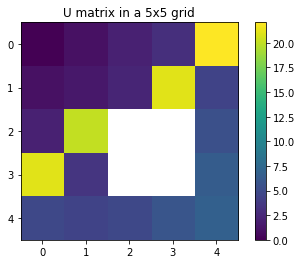

Path computed.
Path:  [array([3, 4]), array([2, 4]), array([1, 4]), array([0, 3]), array([0, 2]), array([0, 1]), array([0, 0])]


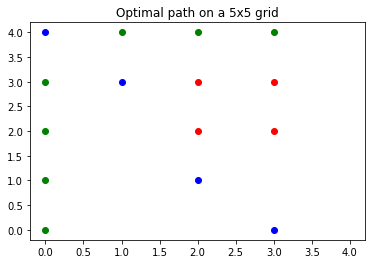

In [9]:
  N = 5
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N//2 + 1, N-1])

  # defining obstacles
      # defining obstacles
  obstacle_list = []
  
  # define a square obstacle
  obstacle_list.append([2, 2, 2, 2])

  # defining cameras
  # camera_list = []
  # # we define a camera C by its position (x,y), its orientation theta and its angle alpha
  # cam_x, cam_y = 0, N-1
  # cam = np.array([cam_x, cam_y])
  # # points towards (2, 0)
  # theta = -np.pi/4
  # alpha = .8
  # camera_list.append([cam, theta, alpha])
  # camera_list = [[np.array([0, N-1]), -np.pi/4, .5]]
  camera_list = [[np.array([0, N-1]), -np.pi/4, 0.4]]

  path, U = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 400/400 [05:07<00:00,  1.30it/s]


U computed.
---------------------


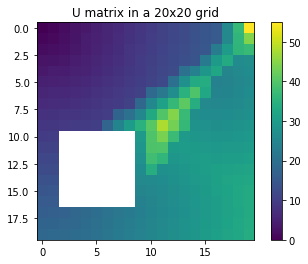

Path computed.
Path:  [array([19, 19]), array([18, 18]), array([17, 17]), array([17, 16]), array([17, 15]), array([17, 14]), array([17, 13]), array([17, 12]), array([17, 11]), array([17, 10]), array([17,  9]), array([17,  8]), array([17,  7]), array([17,  6]), array([17,  5]), array([17,  4]), array([17,  3]), array([17,  2]), array([16,  1]), array([15,  0]), array([14,  0]), array([13,  0]), array([12,  0]), array([11,  0]), array([10,  0]), array([9, 0]), array([8, 0]), array([7, 0]), array([6, 0]), array([5, 0]), array([4, 0]), array([3, 0]), array([2, 0]), array([1, 0]), array([0, 0])]
Path length:  35.65685424949238
--- 307.72449350357056 seconds ---


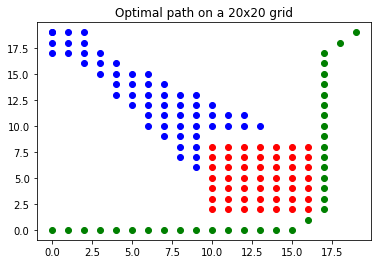

In [ ]:
  N = 20
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = []
  obstacle_list.append([10, 2, 7])
  camera_list = [[np.array([0, N-1]), -np.pi/4, 0.4]]

  start_time = time.time()
  path = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)
  # compute path length with cost_path
  print("Path length: ", cost_path(path))
  print("--- %s seconds ---" % (time.time() - start_time))

  # path = [[0, 0]]

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 400/400 [04:29<00:00,  1.48it/s]


U computed.
---------------------


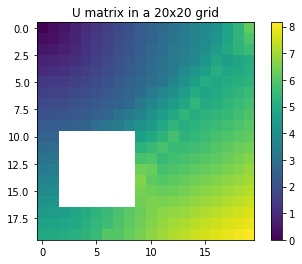

Path computed.
Path:  [array([19, 19]), array([18, 18]), array([17, 17]), array([16, 16]), array([15, 15]), array([14, 14]), array([13, 13]), array([12, 12]), array([11, 12]), array([10, 11]), array([ 9, 10]), array([8, 9]), array([7, 8]), array([6, 7]), array([5, 6]), array([4, 5]), array([3, 4]), array([2, 3]), array([1, 2]), array([0, 1]), array([0, 0])]
Path length:  27.45584412271572
--- 270.2162992954254 seconds ---


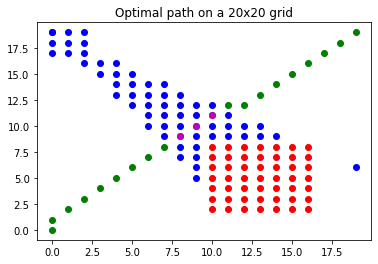

In [ ]:
  N = 20
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = []
  obstacle_list.append([10, 2, 7])
  camera_list = [[np.array([0, N-1]), -0.8, 0.4]]

  start_time = time.time()
  path = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)
  # compute path length with cost_path
  print("Path length: ", cost_path(path))
  print("--- %s seconds ---" % (time.time() - start_time))

  # path = [[0, 0]]

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 400/400 [04:25<00:00,  1.51it/s]


U computed.
---------------------


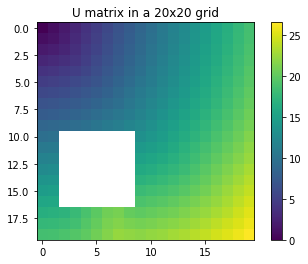

Path computed.
Path:  [array([19, 19]), array([18, 18]), array([17, 17]), array([16, 16]), array([15, 15]), array([14, 14]), array([13, 13]), array([12, 12]), array([11, 11]), array([10, 10]), array([9, 9]), array([8, 8]), array([7, 7]), array([6, 6]), array([5, 5]), array([4, 4]), array([3, 3]), array([2, 2]), array([1, 1]), array([0, 0])]
Path length:  26.870057685088817
--- 265.9583160877228 seconds ---


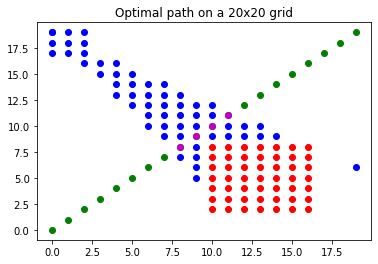

In [ ]:
  N = 20
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = []
  obstacle_list.append([10, 2, 7])
  camera_list = [[np.array([0, N-1]), -0.8, 0.4]]

  start_time = time.time()
  path = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)
  # compute path length with cost_path
  print("Path length: ", cost_path(path))
  print("--- %s seconds ---" % (time.time() - start_time))

  # path = [[0, 0]]

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


U computed.
---------------------


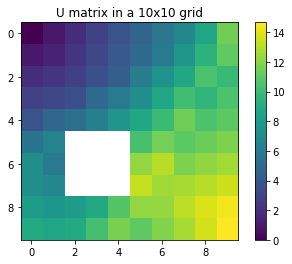

Path computed.
Path:  [array([9, 9]), array([9, 8]), array([9, 7]), array([9, 6]), array([9, 5]), array([8, 4]), array([8, 3]), array([8, 2]), array([7, 1]), array([6, 1]), array([5, 0]), array([4, 0]), array([3, 0]), array([2, 0]), array([1, 0]), array([0, 0])]
Path length:  16.242640687119284
--- 17.16120219230652 seconds ---


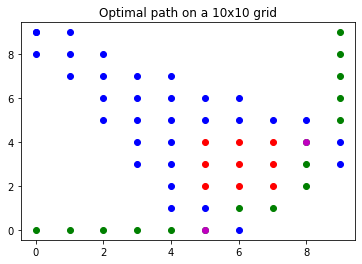

Score : 14.675193953331016


In [ ]:
  N = 10
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = []
  obstacle_list.append([5, 2, 3])
  camera_list = [[np.array([0, 9]), -.8, 0.7]]

  start_time = time.time()
  path, U = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)
  # compute path length with cost_path
  print("Path length: ", cost_path(path))
  print("--- %s seconds ---" % (time.time() - start_time))

  # path = [[0, 0]]
  counter = 0

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
              counter += 1
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

  print("Score :", U[xf[0], xf[1]])

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


U computed.
---------------------


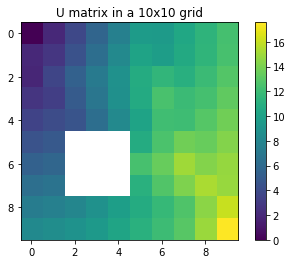

Path computed.
Path:  [array([9, 9]), array([8, 8]), array([8, 7]), array([8, 6]), array([8, 5]), array([8, 4]), array([8, 3]), array([8, 2]), array([7, 1]), array([6, 0]), array([5, 0]), array([4, 0]), array([3, 0]), array([2, 0]), array([1, 0]), array([0, 0])]
Path length:  16.242640687119284
--- 15.893737077713013 seconds ---


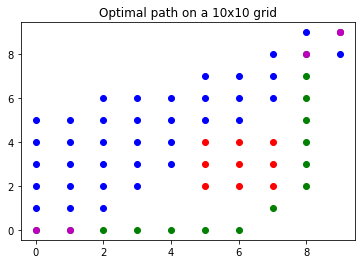

Score : 17.57490143906125


In [ ]:
  N = 10
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = []
  obstacle_list.append([5, 2, 3])
  camera_list = [[np.array([9, 9]), -3*.8, 0.7]]

  start_time = time.time()
  path, U = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)
  # compute path length with cost_path
  print("Path length: ", cost_path(path))
  print("--- %s seconds ---" % (time.time() - start_time))

  # path = [[0, 0]]
  counter = 0

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
              counter += 1
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

  print("Score :", U[xf[0], xf[1]])

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


U computed.
---------------------


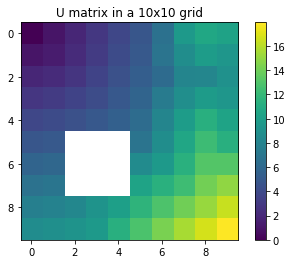

Path computed.
Path:  [array([9, 9]), array([8, 8]), array([7, 7]), array([6, 6]), array([5, 5]), array([4, 4]), array([3, 3]), array([2, 2]), array([1, 1]), array([0, 0])]
Path length:  12.727922061357859
--- 18.1480712890625 seconds ---


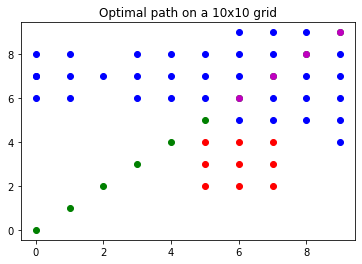

Score : 17.953594156125742


In [ ]:
  N = 10
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = []
  obstacle_list.append([5, 2, 3])
  camera_list = [[np.array([0, 7]), 0.0, 0.7]]

  start_time = time.time()
  path, U = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
  print("Path: ", path)
  # compute path length with cost_path
  print("Path length: ", cost_path(path))
  print("--- %s seconds ---" % (time.time() - start_time))

  # path = [[0, 0]]
  counter = 0

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(N):
          for j in range(N):
              plt.plot(i, j, 'wo')
      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'go')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
              counter += 1
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

  print("Score :", U[xf[0], xf[1]])

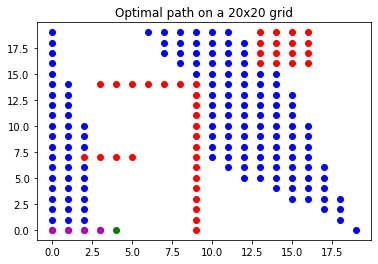

NameError: name 'U' is not defined

In [30]:
  N = 20
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])

  obstacle_list = [[2, 7, 4, 1], [9, 0, 1, 15], [3,14, 6, 1], [13, 16, 4, 4]]
  camera_list = [[np.array([N-1, 0]), 3*.8-0.2, 0.7], [np.array([0, N-1]), -2*.8, 0.5]]
#   camera_list = []

#   path, U = path_finder(N, x0, xf, camera_list,  obstacle_list, saveU=saveU)
#   print("Path: ", path)
#   # compute path length with cost_path
#   print("Path length: ", cost_path(path))

  path = [[i, 0] for i in range(5)]
  counter = 0

  if visualize:
      camera_points = []
      for cam in camera_list:
          # compute visible points
          visible_points = compute_camera_visible_points(cam, obstacle_list, N)
          for point in visible_points:
              camera_points.append(np.array(point))
      
      for camera in camera_list:
          cam, theta, alpha = camera
          camera_points.append(cam)

      for i in range(len(path)):
          plt.plot(path[i][0], path[i][1], 'o-g')
      # visualize obstacle
      for point in obstacles_list_to_points(obstacle_list):
          plt.plot(point[0], point[1], 'ro')
      # visualize camera
      for point in camera_points:
          # if point is not in path
          if not any((point == x).all() for x in path):
              plt.plot(point[0], point[1], 'bo')
          else: # plot in purple
              plt.plot(point[0], point[1], 'mo')
              counter += 1
      plt.title("Optimal path on a {}x{} grid".format(N, N))
      plt.show()

  print("Score :", U[xf[0], xf[1]])

In [31]:
from matplotlib.patches import Polygon, Circle, Rectangle

def visualization(N, camera_list, obstacle_list, pos_start=np.array([-2., -2.]), pos_end=np.array([2., 2.])):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    x_min, y_min, x_max, y_max = -2., -2., 2., 2.

    max_length = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2)

    # ax setup
    ax.axis([x_min, x_max, y_min, y_max])
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

    for i in range(len(camera_list)):
        cam_pos = camera_list[i][0]
        cam_orient = camera_list[i][1]
        cam_angle = camera_list[i][2]/2

        center_base = cam_pos
        direc = np.array([np.cos(cam_orient), np.sin(cam_orient)])
        ortho = np.array([-np.sin(cam_orient), np.cos(cam_orient)])

        vertices = np.stack(
            [cam_pos,
            cam_pos + max_length * (direc + np.sin(cam_angle) * ortho),
            cam_pos + max_length * (direc - np.sin(cam_angle) * ortho)],
            axis=0
        )

        cam_cone_plt = ax.add_patch(Polygon(
            vertices,
            fill=True,
            alpha=.5,
            color=(.7, .7, 0.),
            zorder=3,
            lw=0
        ))

    # example obs
    # obs_pos = np.array([0.8, 0.1])
    # obs_radius = 0.2

    # obs_1_plt = ax.add_patch(Circle(
    #     obs_pos,
    #     obs_radius,
    #     fill=True,
    #     alpha=.5,
    #     color=(.3, .1, .3),
    #     zorder=1,
    #     lw=0
    # ))

    # plot square obstacles
    for obs in obstacle_list:
        # obs is in the form (x, y, c) where (x, y) is the position of the lower left corner and c is the side length
        obs_point = np.array([obs[0], obs[1]])
        width, height = obs[2], obs[3]
        obs_1_plt = ax.add_patch(Rectangle(obs_point, width, height))

    # example traj
    xls = np.linspace(x_min, x_max, N)
    yls = np.linspace(y_min, y_max, N)

    X, Y = np.meshgrid(xls, yls)


    # should come extract from HJ on grid
    # be carefull to use center of cells

    # compute x0 and xf, making transition from real to grid
    x0 = (pos_start - np.array([x_min, y_min])) / (x_max - x_min) * (N - 1)
    xf = (pos_end - np.array([x_min, y_min])) / (x_max - x_min) * (N - 1)
    # convert to int values
    x0 = x0.astype(int)
    xf = xf.astype(int)

    # defining obstacles
    grid_obstacle_list = []
    # convert obstacle_list with real values between -2 and 2 to grid values between 0 and N-1
    for obs in obstacle_list:
        obs_radius_1 = obs[2]
        obs_radius_2 = obs[3]
        # convert obs_pos to grid
        obs_x = (obs[0] - x_min) / (x_max - x_min) * (N - 1)
        obs_y = (obs[1] - y_min) / (y_max - y_min) * (N - 1)
        obs_rad_grid_1 = obs_radius_1 / (x_max - x_min) * (N - 1)
        obs_rad_grid_2 = obs_radius_2 / (y_max - y_min) * (N - 1)
        # convert to int
        obs_x = int(obs_x)
        obs_y = int(obs_y)
        obs_radius_1 = int(obs_rad_grid_1)
        obs_radius_2 = int(obs_rad_grid_2)
        grid_obstacle_list.append([obs_x, obs_y, obs_radius_1, obs_radius_2])

    # defining cameras
    camera_list_grid = []
    for camera in camera_list:
        cam_pos = camera[0]
        cam_orient = camera[1]
        cam_angle = camera[2]
        # convert cam_pos to grid
        cam_x = (cam_pos[0] - x_min) / (x_max - x_min) * (N - 1)
        cam_y = (cam_pos[1] - y_min) / (y_max - y_min) * (N - 1)
        # convert to int
        cam_x = int(cam_x)
        cam_y = int(cam_y)
        cam_ind = np.array([cam_x, cam_y])
        camera_list_grid.append([cam_ind, cam_orient, cam_angle])
    path, U = path_finder(N, x0, xf, camera_list_grid, grid_obstacle_list)
    # convert to real values
    traj = np.zeros((len(path), 2))
    for i in range(len(path)):
        traj[i, 0] = path[i][0] / (N - 1) * (x_max - x_min) + x_min
        traj[i, 1] = path[i][1] / (N - 1) * (y_max - y_min) + y_min

    traj_plt = ax.plot(
        traj[:, 0], traj[:, 1],
        linewidth=0.2,
        color=(.1, .1, .1),
        alpha=1.,
        zorder=2
    )[0]

    # If you want to add the field
    # field_plt = ax.quiver(X, Y, V[:, :, 0], V[:, :, 1])

    plt.subplots_adjust(
        left=0, bottom=0, right=1, top=1, wspace=0, hspace=0
    )
    plt.title("Clean path visualization")
    plt.show(block=False)
    return 3

---------------------
Computing U...
Starting...
Initialization done.


100%|██████████| 400/400 [01:39<00:00,  4.02it/s]

U computed.
---------------------
Path computed.


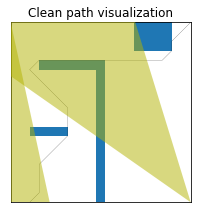

3


In [32]:
  N = 20
  visualize = True
  saveU = True
  
  x0 = np.array([0, 0])
  xf = np.array([N-1, N-1])
  # convert to real between -2 and 2
  pos_start = x0 / (N - 1) * 4 - 2
  pos_end = xf / (N - 1) * 4 - 2

  obstacle_list = [[2, 7, 4, 1], [9, 0, 1, 15], [3,14, 6, 1], [13, 16, 4, 4]]
  camera_list = [[np.array([N-1, 0]), 3*.8-0.2, 0.7], [np.array([0, N-1]), -2*.8, 0.5]]

  # convert to real between -2 and 2
  obstacle_list = [[obs[0] / (N - 1) * 4 - 2, obs[1] / (N - 1) * 4 - 2, obs[2] / (N - 1) * 4, obs[3] / (N - 1) * 4] for obs in obstacle_list]
  # convert to real between -2 and 2
  camera_list = [[np.array([cam[0][0] / (N - 1) * 4 - 2, cam[0][1] / (N - 1) * 4 - 2]), cam[1], cam[2]] for cam in camera_list]
  a = visualization(N, camera_list, obstacle_list, pos_start, pos_end)
  print(a)